# Class 10 & 11: Principal Components Analysis, Regression, and K-Nearest Neighbors

In [1]:
%matplotlib inline
import numpy as np #Our usual preliminary invocation
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Last week, we learned about Principal Components Analysis, a powerful technique for dimensionality reduction and feature creation. To see what PCA does in practice (and to understand how to implement it using scikit-learn) let's consider some examples. First, an example from the *Python Data Science Handbook*. Let's first create a toy data set. 

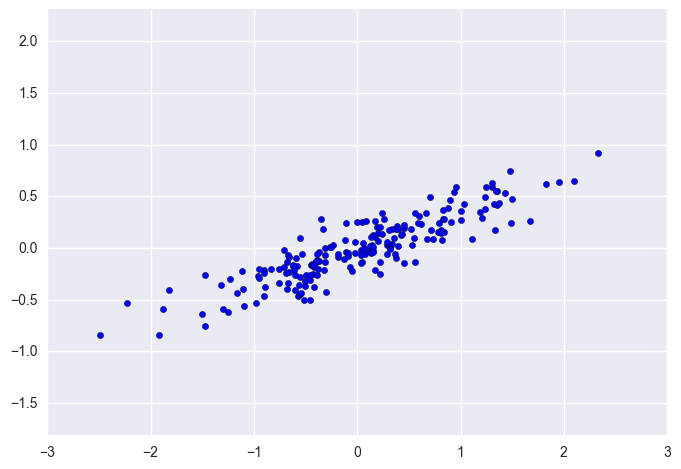

In [2]:
rng = np.random.RandomState(1) #Remember, this allows us to replicate draws from our random number generator. 
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T #This creates 200 draws from a bivariate normal with zero mean
#and a random covariance matrix
plt.scatter(X[:, 0], X[:, 1]) #Usual plotting routine
plt.axis('equal');

You can more or less see that there is ONE axis along which the variation is much more substantial. We could just pick this out with our eyes, but we want the computer to do this for us. Fortunately, that is just what PCA is for!

In [3]:
from sklearn.decomposition import PCA #Note two things: first, the name of the PCA learner. 
#Second, where to look for other sklearn functions that work via matrix decomposition. 
#These are mostly useful for dimensionality reduction
pca = PCA(n_components=2) #Creates a learner which only returns the first (n_components = 2) principal components.
#Of course in this case, you can't return more than 2 components. What would happen if we changed this?
pca.fit(X) #The familiar fit method. 

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Remember that PCA returns both the eigenvalues and the eigenvectors. To inspect the eigenvectors (the first n_components principal components) we use the following method of the learner: 

In [4]:
print(pca.components_) #We can look at the components. Note how these are grouped. 

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


Recall that these components are supposed to be orthogonal. That means that their dot product (which Mark will define shortly) will be zero. 

In [5]:
np.dot(pca.components_[0],pca.components_[1]) #Take the dot product of the two vectors

0.0

We also want to inspect the eigenvalues. Recall that the largest ("leading") eigenvalue is identical to the variance of the first principal component; the second largest eigenvalue is the varliance of the second principal component, etc. In general, $\mathrm{Var}(PC_i) = \lambda_i$.

In [6]:
print(pca.explained_variance_) #As you can see, the first PC has much more variance than the second. 

[ 0.75871884  0.01838551]


In [7]:
print(pca.explained_variance_ratio_) #This would be a good situation for only taking the first PC
#This is telling us that 98% of the dataset's variance is along the first PC

[ 0.97634101  0.02365899]


It's easy to visualize exactly what is going on here... to confirm the intuition that we got from visual inspection.

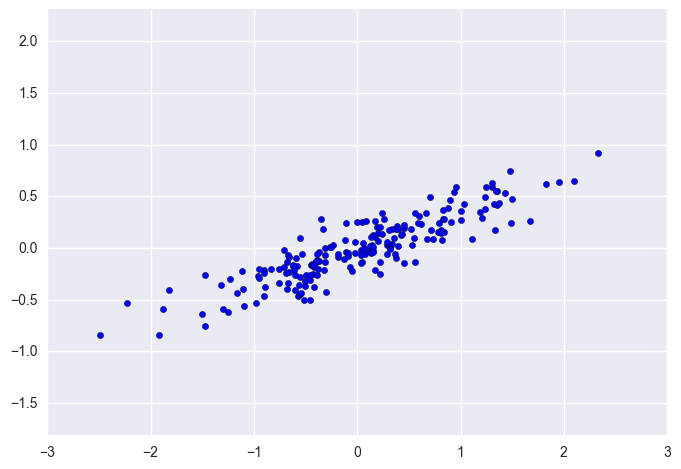

In [8]:
plt.scatter(X[:, 0], X[:, 1]) #What direction do you think corresponds to the first PC? The second? 
plt.axis('equal');

In [9]:
def draw_vector(v0, v1, ax=None): #This is a little utility function for plotting vectors
    ax = ax or plt.gca() 
    arrowprops=dict(arrowstyle='->',
                        linewidth=2,
                        shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

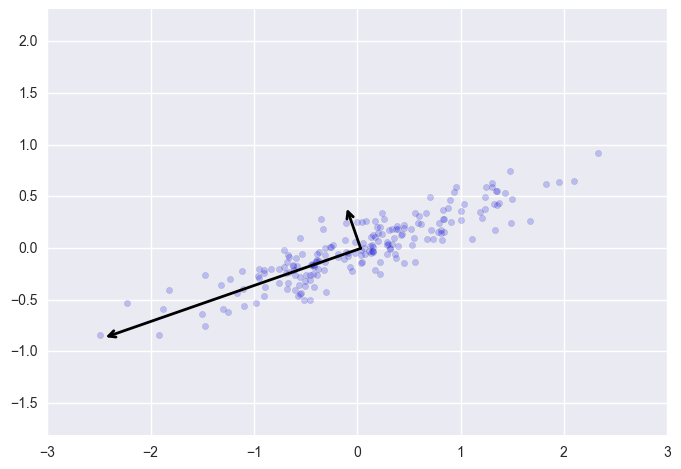

In [10]:
# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2) #Plot the original data, making them a bit faint with alpha
for length, vector in zip(pca.explained_variance_, pca.components_): #Zip is a nice utility function in Python
    v = vector * 3 * np.sqrt(length) #Scales each vector by the std dev of the appropriate PC 
    draw_vector(pca.mean_, pca.mean_ + v) #One end of the vector goes at the empirical mean
                                          #The other end is displaced in the direction of the PC, scaled by 3*std dev
plt.axis('equal');

In [11]:
print(pca.components_) #Which is consistent with this 

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


Of course, the point of doing this is often *dimensionality reduction*, i.e., to take a high dimensional object and represent it in lower dimensions. Do you think we really need two dimensions to describe these data?

In [12]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X) #The transform method of our PCA learner object *projects* the data onto the retained PCs
print("original shape: ", X.shape) #This shows the dimensionality of the original data
print("transformed shape:", X_pca.shape) #This shows the dimensionality of the transformed data

original shape:  (200, 2)
transformed shape: (200, 1)


This transformation is *lossy* -- we have eliminated the information in the second PC. To see what we have retained, we can *invert* the transformation and map our reduced data back into the original coordinate system. 

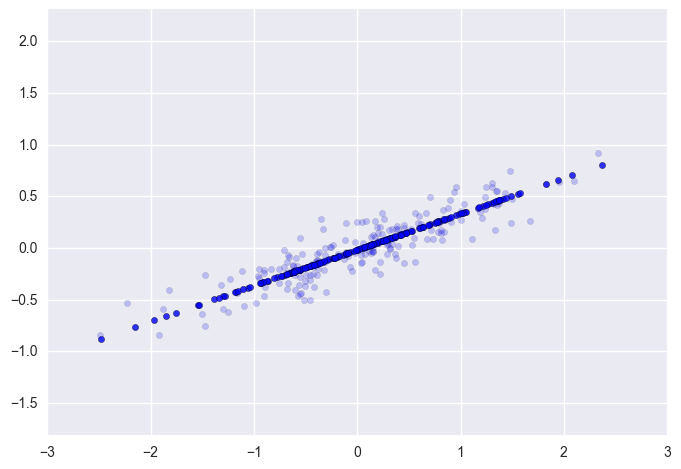

In [13]:
X_new = pca.inverse_transform(X_pca) #This inverts the transformation 
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

So far, these have been "baby" examples. In particular, we didn't have a lot of choice about the number of components to keep (1 or 2) and there wasn't an obvious reason to reduce dimensionality anyway. That said, we can use this simple case to introduce some functions for deciding how many components to keep. 

In [14]:
pca = PCA() #Note that I now allow the full number of components
pca.fit(X) #This will learn *all* the components
pca.explained_variance_ratio_

array([ 0.97634101,  0.02365899])

An obvious thing to try: let's keep exactly the number of components required to explain some percent, say, $95\%$ of the variance.

In [15]:
pca=PCA(n_components = 0.95) #This imposes exactly that restriction
pca.fit(X)
pca.explained_variance_ratio_ #It works!

array([ 0.97634101])

Now that we know how to do this, let's play with something less trivial. Again following *PDSH*, let's use those digits from our discussion of K Means.

In [16]:
from sklearn.datasets import load_digits 
digits = load_digits()
digits.data.shape 

(1797, 64)

This is a great candidate for useful dimensionality reduction; this dataset intrinsically has 64 dimensions. As we recall from last week, there are 10 clusters in these data, corresponding roughly to the 10 digits.

In [17]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=10, random_state=0) #Familiar syntax. We look for 10 clusters because there are 10 digits. 
digit_clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape #The centers have ten entries (the 10 centers)
#Each of these IS in fact a point in 64 dimensions, which we can fold into 8 by 8 and visualize.

(10, 64)

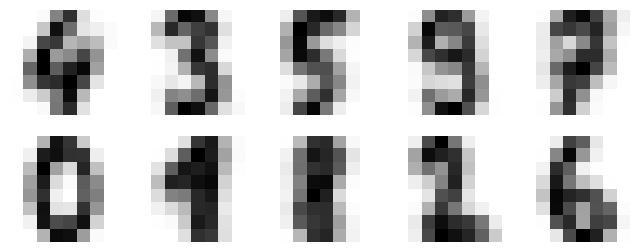

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))  #And we can just visualize these...
centers = kmeans.cluster_centers_.reshape(10, 8, 8) 
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Why might we want to do dimensionality reduction? One common reason is for visualization. If we are visualizing, of cousre, we usually want to reduce to 2 dimensions. 

In [19]:
pca = PCA(2) # This only keeps the first two principal components. 
projected = pca.fit_transform(digits.data) #The combined fit_transform method finds the PCs and then transforms the data
print(digits.data.shape) 
print(projected.shape) #As you can see the transformation has worked. 

(1797, 64)
(1797, 2)


If we plot the reduced data in two dimensions, we see that in many cases the first two PCs are doing a great job of separating the different digits. 

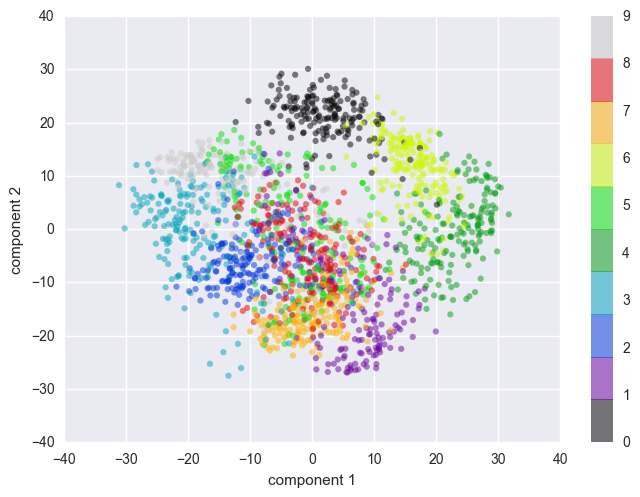

In [20]:
plt.scatter(projected[:, 0], projected[:, 1],
        c=digits.target, edgecolor='none', alpha=0.5,
        cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Note that many of the adjacencies also make sense, e.g., 1 is next to 7...

Let's say, however, that we are using PCA for feature extraction. Then we might care about keeping the number of components that explains a certain amount of variance. 

In [21]:
pca = PCA() #No imposed restrictions on number of components. That means it will find all 64 of them. 
pca.fit(digits.data)
print(pca.explained_variance_ratio_) #It looks like the first few are pretty important...

[  1.48905936e-01   1.36187712e-01   1.17945938e-01   8.40997942e-02
   5.78241466e-02   4.91691032e-02   4.31598701e-02   3.66137258e-02
   3.35324810e-02   3.07880621e-02   2.37234084e-02   2.27269657e-02
   1.82186331e-02   1.77385494e-02   1.46710109e-02   1.40971560e-02
   1.31858920e-02   1.24813782e-02   1.01771796e-02   9.05617439e-03
   8.89538461e-03   7.97123157e-03   7.67493255e-03   7.22903569e-03
   6.95888851e-03   5.96081458e-03   5.75614688e-03   5.15157582e-03
   4.89539777e-03   4.28887968e-03   3.73606048e-03   3.53274223e-03
   3.36683986e-03   3.28029851e-03   3.08320884e-03   2.93778629e-03
   2.56588609e-03   2.27742397e-03   2.22277922e-03   2.11430393e-03
   1.89909062e-03   1.58652907e-03   1.51159934e-03   1.40578764e-03
   1.16622290e-03   1.07492521e-03   9.64053065e-04   7.74630271e-04
   5.57211553e-04   4.04330693e-04   2.09916327e-04   8.24797098e-05
   5.25149980e-05   5.05243719e-05   3.29961363e-05   1.24365445e-05
   7.04827911e-06   3.01432139e-06

In [22]:
pca = PCA(n_components = 0.95).fit(digits.data) #Note that you can compress the code a bit
transformed_digits = pca.transform(digits.data)
transformed_digits.shape

(1797, 29)

So we would need to keep quite a few components to account for most of the variation in the data. There's actually a nice way to visualize this:

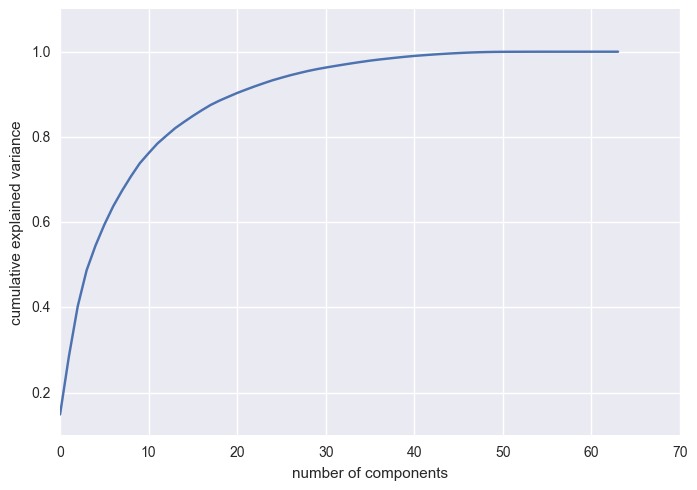

In [23]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Nevertheless, we've cut down by roughly $50\%$ the dimensionality of the data. This can be really helpful in practice; in essence, we have PCA as a form of **data compression**. To see this, here's a little utility function for visualizing the first few digits.

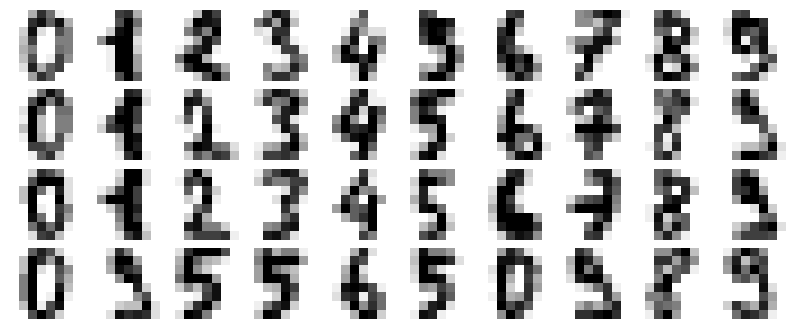

In [24]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                            subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1)) 
    for i, ax in enumerate(axes.flat):
            ax.imshow(data[i].reshape(8, 8),
                      cmap='binary', interpolation='nearest',
                      clim=(0, 16))
plot_digits(digits.data)

How much violence does a substantial compression do to our data? Let's do PCA, but preserve only $80\%$ of the variance. 

In [25]:
pca = PCA(0.80).fit(digits.data)
pca.n_components_

13

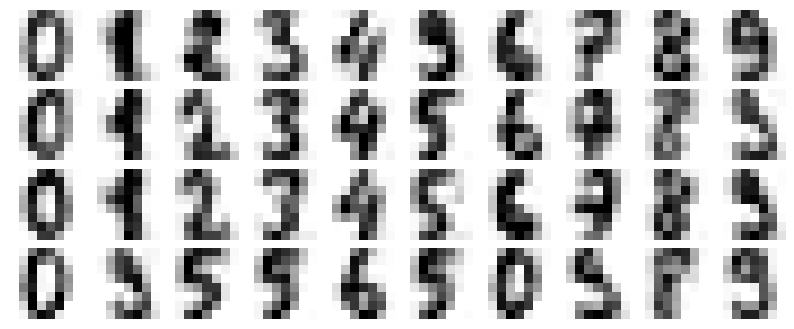

In [26]:
transform_digits_80 = pca.transform(digits.data)
inverse_digits_80 = pca.inverse_transform(transform_digits_80)
plot_digits(inverse_digits_80)

As you can see, we didn't lose much by doing this!

In addition to compressing our data, we can also use PCA to **filter out noise**. 

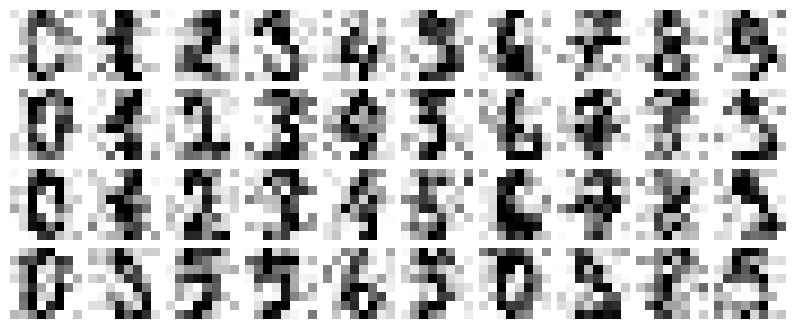

In [27]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy) #We have just added some random noise to the real digits. But as you can see, this makes them a mess!

In [28]:
pca = PCA(0.50).fit(noisy) #Nonetheless, we might hope that the presence of the original digits in there creates
#some reliable directions where most of the variation occurs 
pca.n_components_
#Note that if we keep too many principle components (try to account for too much of the variation) 
#then we miss out on the noise-filtering. 

12

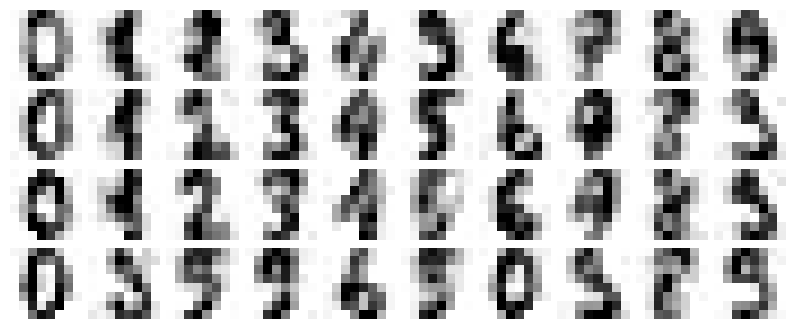

In [29]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

And we have largely recovered the original data, cleaning up the vast majority of the distorting noise. 